In [1]:
import numpy as np
import torch

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')

In [2]:
# parameters
dataset_name = ""
model_name = "resnet_ce_mse"
ood = ""

In [3]:
# Parameters
dataset_name = "QPM_species"
ood = "0:2:3"


In [4]:
# initialize data attributes and loaders
from config import load_config

config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

In [5]:
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

Dataset type train label type: species


Loaded 42153 images
Dataset type val label type: species


Loaded 5269 images
Dataset type test label type: species


Loaded 5270 images
Dataset type test label type: species


Loaded 43520 images


In [6]:
# model ids
import pandas as pd
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

0:2:3 1y6ktp79


In [7]:
model = config.get_model()

In [8]:
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger

artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb: Downloading large artifact model-1y6ktp79:best, 58.48MB. 1 files... 


wandb:   1 of 1 files downloaded.  


Done. 0:0:0.2


In [9]:
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [10]:
from tqdm import tqdm

with torch.no_grad():
    trn_inp = []
    trn_rcn = []
    trn_emb = []
    trn_lgt = []
    trn_tgt = []

    val_inp = []
    val_rcn = []
    val_emb = []
    val_lgt = []
    val_tgt = []

    ind_inp = []
    ind_rcn = []
    ind_emb = []
    ind_lgt = []
    ind_tgt = []

    if ood_str:
        ood_inp = []
        ood_rcn = []
        ood_emb = []
        ood_lgt = []
        ood_tgt = []

    rnd_inp = []
    rnd_rcn = []
    rnd_emb = []
    rnd_lgt = []

    # train set (ind)
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        trn_inp.extend(x.detach().cpu().numpy())
        trn_rcn.extend(rcn.detach().cpu().numpy())
        trn_emb.extend(emb.detach().cpu().numpy())
        trn_lgt.extend(lgt.detach().cpu().numpy())
        trn_tgt.extend(y.detach().cpu().numpy())
    print("train - OK")

    # val set (ind)
    for batch_idx, batch in enumerate(tqdm(val_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        val_inp.extend(x.detach().cpu().numpy())
        val_rcn.extend(rcn.detach().cpu().numpy())
        val_emb.extend(emb.detach().cpu().numpy())
        val_lgt.extend(lgt.detach().cpu().numpy())
        val_tgt.extend(y.detach().cpu().numpy())
    print("val - OK")

    # test set (ind)
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        ind_inp.extend(x.detach().cpu().numpy())
        ind_rcn.extend(rcn.detach().cpu().numpy())
        ind_emb.extend(emb.detach().cpu().numpy())
        ind_lgt.extend(lgt.detach().cpu().numpy())
        ind_tgt.extend(y.detach().cpu().numpy())
    print("test InD - OK")

    # predict set (ood)
    if ood_str:
        for batch_idx, batch in enumerate(tqdm(predict_loader)):
            x, y, *_ = batch
            x = x.float().cuda()
            emb, lgt, rcn = model(x)
            ood_inp.extend(x.detach().cpu().numpy())
            ood_rcn.extend(rcn.detach().cpu().numpy())
            ood_emb.extend(emb.detach().cpu().numpy())
            ood_lgt.extend(lgt.detach().cpu().numpy())
            ood_tgt.extend(y.detach().cpu().numpy())
        print("test OoD - OK")

    # random set
    rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
    for batch_idx, batch in enumerate(tqdm(rnd_set)):
        x = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        rnd_inp.extend(x.detach().cpu().numpy())
        rnd_rcn.extend(rcn.detach().cpu().numpy())
        rnd_emb.extend(emb.detach().cpu().numpy())
        rnd_lgt.extend(lgt.detach().cpu().numpy())
    print("test RnD - OK")

  0%|                                                                              | 0/659 [00:00<?, ?it/s]

  0%|                                                                      | 1/659 [00:00<05:53,  1.86it/s]

  1%|▋                                                                     | 7/659 [00:00<00:48, 13.52it/s]

  2%|█▎                                                                   | 12/659 [00:00<00:30, 21.10it/s]

  3%|█▊                                                                   | 17/659 [00:00<00:23, 27.15it/s]

  3%|██▎                                                                  | 22/659 [00:00<00:20, 31.81it/s]

  4%|██▊                                                                  | 27/659 [00:01<00:17, 35.32it/s]

  5%|███▎                                                                 | 32/659 [00:01<00:16, 37.91it/s]

  6%|███▊                                                                 | 37/659 [00:01<00:15, 39.80it/s]

  6%|████▍                                                                | 42/659 [00:01<00:14, 41.15it/s]

  7%|████▉                                                                | 47/659 [00:01<00:14, 42.12it/s]

  8%|█████▍                                                               | 52/659 [00:01<00:14, 42.78it/s]

  9%|█████▉                                                               | 57/659 [00:01<00:13, 43.23it/s]

  9%|██████▍                                                              | 62/659 [00:01<00:13, 43.57it/s]

 10%|███████                                                              | 67/659 [00:02<00:13, 43.82it/s]

 11%|███████▌                                                             | 72/659 [00:02<00:13, 43.99it/s]

 12%|████████                                                             | 77/659 [00:02<00:13, 44.14it/s]

 12%|████████▌                                                            | 82/659 [00:02<00:13, 44.20it/s]

 13%|█████████                                                            | 87/659 [00:02<00:12, 44.30it/s]

 14%|█████████▋                                                           | 92/659 [00:02<00:12, 44.30it/s]

 15%|██████████▏                                                          | 97/659 [00:02<00:12, 44.45it/s]

 15%|██████████▌                                                         | 102/659 [00:02<00:12, 44.54it/s]

 16%|███████████                                                         | 107/659 [00:02<00:12, 44.59it/s]

 17%|███████████▌                                                        | 112/659 [00:03<00:12, 44.63it/s]

 18%|████████████                                                        | 117/659 [00:03<00:12, 45.04it/s]

 19%|████████████▋                                                       | 123/659 [00:03<00:11, 46.43it/s]

 19%|█████████████▏                                                      | 128/659 [00:03<00:11, 45.93it/s]

 20%|█████████████▋                                                      | 133/659 [00:03<00:11, 45.57it/s]

 21%|██████████████▏                                                     | 138/659 [00:03<00:11, 45.35it/s]

 22%|██████████████▊                                                     | 143/659 [00:03<00:11, 45.16it/s]

 22%|███████████████▎                                                    | 148/659 [00:03<00:11, 45.04it/s]

 23%|███████████████▊                                                    | 153/659 [00:03<00:11, 44.94it/s]

 24%|████████████████▎                                                   | 158/659 [00:04<00:11, 44.92it/s]

 25%|████████████████▊                                                   | 163/659 [00:04<00:11, 44.87it/s]

 25%|█████████████████▎                                                  | 168/659 [00:04<00:10, 44.81it/s]

 26%|█████████████████▊                                                  | 173/659 [00:04<00:10, 44.76it/s]

 27%|██████████████████▎                                                 | 178/659 [00:04<00:10, 44.75it/s]

 28%|██████████████████▉                                                 | 183/659 [00:04<00:10, 44.77it/s]

 29%|███████████████████▍                                                | 188/659 [00:04<00:10, 44.77it/s]

 29%|███████████████████▉                                                | 193/659 [00:04<00:10, 44.72it/s]

 30%|████████████████████▍                                               | 198/659 [00:04<00:10, 44.70it/s]

 31%|████████████████████▉                                               | 203/659 [00:05<00:10, 44.69it/s]

 32%|█████████████████████▍                                              | 208/659 [00:05<00:10, 44.72it/s]

 32%|█████████████████████▉                                              | 213/659 [00:05<00:09, 44.74it/s]

 33%|██████████████████████▍                                             | 218/659 [00:05<00:09, 44.70it/s]

 34%|███████████████████████                                             | 223/659 [00:05<00:09, 44.71it/s]

 35%|███████████████████████▌                                            | 228/659 [00:05<00:09, 44.68it/s]

 35%|████████████████████████                                            | 233/659 [00:05<00:09, 44.67it/s]

 36%|████████████████████████▌                                           | 238/659 [00:05<00:09, 44.67it/s]

 37%|█████████████████████████                                           | 243/659 [00:05<00:09, 44.71it/s]

 38%|█████████████████████████▌                                          | 248/659 [00:06<00:09, 44.74it/s]

 38%|██████████████████████████                                          | 253/659 [00:06<00:09, 44.71it/s]

 39%|██████████████████████████▌                                         | 258/659 [00:06<00:08, 44.73it/s]

 40%|███████████████████████████▏                                        | 263/659 [00:06<00:08, 44.73it/s]

 41%|███████████████████████████▋                                        | 268/659 [00:06<00:08, 44.71it/s]

 41%|████████████████████████████▏                                       | 273/659 [00:06<00:08, 44.71it/s]

 42%|████████████████████████████▋                                       | 278/659 [00:06<00:08, 44.70it/s]

 43%|█████████████████████████████▏                                      | 283/659 [00:06<00:08, 44.70it/s]

 44%|█████████████████████████████▋                                      | 288/659 [00:06<00:08, 44.68it/s]

 44%|██████████████████████████████▏                                     | 293/659 [00:07<00:08, 44.72it/s]

 45%|██████████████████████████████▋                                     | 298/659 [00:07<00:08, 44.72it/s]

 46%|███████████████████████████████▎                                    | 303/659 [00:07<00:07, 44.67it/s]

 47%|███████████████████████████████▊                                    | 308/659 [00:07<00:07, 44.66it/s]

 47%|████████████████████████████████▎                                   | 313/659 [00:07<00:07, 44.66it/s]

 48%|████████████████████████████████▊                                   | 318/659 [00:07<00:07, 44.68it/s]

 49%|█████████████████████████████████▎                                  | 323/659 [00:07<00:07, 44.65it/s]

 50%|█████████████████████████████████▊                                  | 328/659 [00:07<00:07, 44.71it/s]

 51%|██████████████████████████████████▎                                 | 333/659 [00:07<00:07, 44.69it/s]

 51%|██████████████████████████████████▉                                 | 338/659 [00:08<00:07, 44.66it/s]

 52%|███████████████████████████████████▍                                | 343/659 [00:08<00:07, 44.69it/s]

 53%|███████████████████████████████████▉                                | 348/659 [00:08<00:06, 44.71it/s]

 54%|████████████████████████████████████▍                               | 353/659 [00:08<00:06, 44.71it/s]

 54%|████████████████████████████████████▉                               | 358/659 [00:08<00:06, 44.70it/s]

 55%|█████████████████████████████████████▍                              | 363/659 [00:08<00:06, 44.68it/s]

 56%|█████████████████████████████████████▉                              | 368/659 [00:08<00:06, 44.68it/s]

 57%|██████████████████████████████████████▍                             | 373/659 [00:08<00:06, 44.71it/s]

 57%|███████████████████████████████████████                             | 378/659 [00:08<00:06, 44.71it/s]

 58%|███████████████████████████████████████▌                            | 383/659 [00:09<00:06, 44.72it/s]

 59%|████████████████████████████████████████                            | 388/659 [00:09<00:06, 44.74it/s]

 60%|████████████████████████████████████████▌                           | 393/659 [00:09<00:05, 44.74it/s]

 60%|█████████████████████████████████████████                           | 398/659 [00:09<00:05, 44.73it/s]

 61%|█████████████████████████████████████████▌                          | 403/659 [00:09<00:05, 44.75it/s]

 62%|██████████████████████████████████████████                          | 408/659 [00:09<00:05, 44.75it/s]

 63%|██████████████████████████████████████████▌                         | 413/659 [00:09<00:05, 44.73it/s]

 63%|███████████████████████████████████████████▏                        | 418/659 [00:09<00:05, 44.75it/s]

 64%|███████████████████████████████████████████▋                        | 423/659 [00:09<00:05, 44.74it/s]

 65%|████████████████████████████████████████████▏                       | 428/659 [00:10<00:05, 44.75it/s]

 66%|████████████████████████████████████████████▋                       | 433/659 [00:10<00:05, 44.75it/s]

 66%|█████████████████████████████████████████████▏                      | 438/659 [00:10<00:04, 44.72it/s]

 67%|█████████████████████████████████████████████▋                      | 443/659 [00:10<00:04, 44.71it/s]

 68%|██████████████████████████████████████████████▏                     | 448/659 [00:10<00:04, 44.71it/s]

 69%|██████████████████████████████████████████████▋                     | 453/659 [00:10<00:04, 44.70it/s]

 69%|███████████████████████████████████████████████▎                    | 458/659 [00:10<00:04, 44.73it/s]

 70%|███████████████████████████████████████████████▊                    | 463/659 [00:10<00:04, 44.71it/s]

 71%|████████████████████████████████████████████████▎                   | 468/659 [00:10<00:04, 44.69it/s]

 72%|████████████████████████████████████████████████▊                   | 473/659 [00:11<00:04, 44.67it/s]

 73%|█████████████████████████████████████████████████▎                  | 478/659 [00:11<00:04, 44.68it/s]

 73%|█████████████████████████████████████████████████▊                  | 483/659 [00:11<00:03, 44.73it/s]

 74%|██████████████████████████████████████████████████▎                 | 488/659 [00:11<00:03, 44.71it/s]

 75%|██████████████████████████████████████████████████▊                 | 493/659 [00:11<00:03, 44.76it/s]

 76%|███████████████████████████████████████████████████▍                | 498/659 [00:11<00:03, 44.77it/s]

 76%|███████████████████████████████████████████████████▉                | 503/659 [00:11<00:03, 44.77it/s]

 77%|████████████████████████████████████████████████████▍               | 508/659 [00:11<00:03, 44.74it/s]

 78%|████████████████████████████████████████████████████▉               | 513/659 [00:11<00:03, 44.74it/s]

 79%|█████████████████████████████████████████████████████▍              | 518/659 [00:12<00:03, 44.72it/s]

 79%|█████████████████████████████████████████████████████▉              | 523/659 [00:12<00:03, 44.77it/s]

 80%|██████████████████████████████████████████████████████▍             | 528/659 [00:12<00:02, 44.73it/s]

 81%|██████████████████████████████████████████████████████▉             | 533/659 [00:12<00:02, 44.75it/s]

 82%|███████████████████████████████████████████████████████▌            | 538/659 [00:12<00:02, 44.72it/s]

 82%|████████████████████████████████████████████████████████            | 543/659 [00:12<00:02, 44.71it/s]

 83%|████████████████████████████████████████████████████████▌           | 548/659 [00:12<00:02, 44.70it/s]

 84%|█████████████████████████████████████████████████████████           | 553/659 [00:12<00:02, 44.67it/s]

 85%|█████████████████████████████████████████████████████████▌          | 558/659 [00:12<00:02, 44.71it/s]

 85%|██████████████████████████████████████████████████████████          | 563/659 [00:13<00:02, 46.00it/s]

 86%|██████████████████████████████████████████████████████████▌         | 568/659 [00:13<00:01, 46.79it/s]

 87%|███████████████████████████████████████████████████████████▎        | 575/659 [00:13<00:01, 51.98it/s]

 89%|████████████████████████████████████████████████████████████▎       | 584/659 [00:13<00:01, 61.07it/s]

 90%|█████████████████████████████████████████████████████████████▏      | 593/659 [00:13<00:00, 67.43it/s]

 91%|██████████████████████████████████████████████████████████████      | 602/659 [00:13<00:00, 71.86it/s]

 93%|███████████████████████████████████████████████████████████████     | 611/659 [00:13<00:00, 74.95it/s]

 94%|███████████████████████████████████████████████████████████████▉    | 620/659 [00:13<00:00, 77.23it/s]

 95%|████████████████████████████████████████████████████████████████▊   | 628/659 [00:13<00:00, 70.43it/s]

 97%|█████████████████████████████████████████████████████████████████▋  | 636/659 [00:14<00:00, 61.11it/s]

 98%|██████████████████████████████████████████████████████████████████▎ | 643/659 [00:14<00:00, 55.66it/s]

 98%|██████████████████████████████████████████████████████████████████▉ | 649/659 [00:14<00:00, 52.34it/s]

 99%|███████████████████████████████████████████████████████████████████▌| 655/659 [00:14<00:00, 50.08it/s]

100%|████████████████████████████████████████████████████████████████████| 659/659 [00:14<00:00, 44.83it/s]

train - OK


  0%|                                                                               | 0/83 [00:00<?, ?it/s]

  1%|▊                                                                      | 1/83 [00:00<00:09,  8.22it/s]

  7%|█████▏                                                                 | 6/83 [00:00<00:02, 28.84it/s]

 13%|█████████▎                                                            | 11/83 [00:00<00:02, 35.93it/s]

 19%|█████████████▍                                                        | 16/83 [00:00<00:01, 39.28it/s]

 25%|█████████████████▋                                                    | 21/83 [00:00<00:01, 41.22it/s]

 33%|██████████████████████▊                                               | 27/83 [00:00<00:01, 44.35it/s]

 39%|██████████████████████████▉                                           | 32/83 [00:00<00:01, 44.40it/s]

 45%|███████████████████████████████▏                                      | 37/83 [00:00<00:01, 44.48it/s]

 51%|███████████████████████████████████▍                                  | 42/83 [00:01<00:00, 44.50it/s]

 57%|███████████████████████████████████████▋                              | 47/83 [00:01<00:00, 44.51it/s]

 63%|███████████████████████████████████████████▊                          | 52/83 [00:01<00:00, 45.32it/s]

 69%|████████████████████████████████████████████████                      | 57/83 [00:01<00:00, 46.40it/s]

 75%|████████████████████████████████████████████████████▎                 | 62/83 [00:01<00:00, 45.87it/s]

 81%|████████████████████████████████████████████████████████▌             | 67/83 [00:01<00:00, 45.49it/s]

 87%|████████████████████████████████████████████████████████████▋         | 72/83 [00:01<00:00, 45.64it/s]

 94%|█████████████████████████████████████████████████████████████████▊    | 78/83 [00:01<00:00, 46.92it/s]

100%|██████████████████████████████████████████████████████████████████████| 83/83 [00:01<00:00, 43.80it/s]

100%|██████████████████████████████████████████████████████████████████████| 83/83 [00:01<00:00, 42.15it/s]

val - OK


  0%|                                                                               | 0/83 [00:00<?, ?it/s]

  1%|▊                                                                      | 1/83 [00:00<00:10,  7.85it/s]

  7%|█████▏                                                                 | 6/83 [00:00<00:02, 29.90it/s]

 13%|█████████▎                                                            | 11/83 [00:00<00:01, 36.67it/s]

 19%|█████████████▍                                                        | 16/83 [00:00<00:01, 39.84it/s]

 25%|█████████████████▋                                                    | 21/83 [00:00<00:01, 41.53it/s]

 31%|█████████████████████▉                                                | 26/83 [00:00<00:01, 42.95it/s]

 39%|██████████████████████████▉                                           | 32/83 [00:00<00:01, 45.31it/s]

 45%|███████████████████████████████▏                                      | 37/83 [00:00<00:01, 45.07it/s]

 51%|███████████████████████████████████▍                                  | 42/83 [00:01<00:00, 44.91it/s]

 57%|███████████████████████████████████████▋                              | 47/83 [00:01<00:00, 45.26it/s]

 64%|████████████████████████████████████████████▋                         | 53/83 [00:01<00:00, 46.69it/s]

 70%|████████████████████████████████████████████████▉                     | 58/83 [00:01<00:00, 46.04it/s]

 76%|█████████████████████████████████████████████████████▏                | 63/83 [00:01<00:00, 45.63it/s]

 82%|█████████████████████████████████████████████████████████▎            | 68/83 [00:01<00:00, 45.36it/s]

 88%|█████████████████████████████████████████████████████████████▌        | 73/83 [00:01<00:00, 44.99it/s]

 94%|█████████████████████████████████████████████████████████████████▊    | 78/83 [00:01<00:00, 44.91it/s]

100%|██████████████████████████████████████████████████████████████████████| 83/83 [00:01<00:00, 42.77it/s]

100%|██████████████████████████████████████████████████████████████████████| 83/83 [00:01<00:00, 41.91it/s]

test InD - OK


  0%|                                                                              | 0/680 [00:00<?, ?it/s]

  0%|                                                                      | 1/680 [00:00<01:30,  7.53it/s]

  1%|▌                                                                     | 6/680 [00:00<00:24, 27.83it/s]

  2%|█                                                                    | 11/680 [00:00<00:18, 35.24it/s]

  2%|█▌                                                                   | 16/680 [00:00<00:17, 38.82it/s]

  3%|██▏                                                                  | 21/680 [00:00<00:15, 41.26it/s]

  4%|██▋                                                                  | 27/680 [00:00<00:14, 44.30it/s]

  5%|███▏                                                                 | 32/680 [00:00<00:14, 44.39it/s]

  5%|███▊                                                                 | 37/680 [00:00<00:14, 44.47it/s]

  6%|████▎                                                                | 42/680 [00:01<00:14, 44.48it/s]

  7%|████▊                                                                | 47/680 [00:01<00:14, 44.42it/s]

  8%|█████▎                                                               | 52/680 [00:01<00:14, 44.44it/s]

  8%|█████▊                                                               | 57/680 [00:01<00:14, 44.47it/s]

  9%|██████▎                                                              | 62/680 [00:01<00:13, 44.43it/s]

 10%|██████▊                                                              | 67/680 [00:01<00:13, 44.40it/s]

 11%|███████▎                                                             | 72/680 [00:01<00:13, 44.38it/s]

 11%|███████▊                                                             | 77/680 [00:01<00:13, 44.71it/s]

 12%|████████▍                                                            | 83/680 [00:01<00:12, 46.31it/s]

 13%|████████▉                                                            | 88/680 [00:02<00:12, 45.83it/s]

 14%|█████████▍                                                           | 93/680 [00:02<00:12, 45.46it/s]

 14%|█████████▉                                                           | 98/680 [00:02<00:12, 45.22it/s]

 15%|██████████▎                                                         | 103/680 [00:02<00:12, 45.08it/s]

 16%|██████████▊                                                         | 108/680 [00:02<00:12, 45.34it/s]

 17%|███████████▍                                                        | 114/680 [00:02<00:12, 46.69it/s]

 18%|███████████▉                                                        | 119/680 [00:02<00:12, 46.14it/s]

 18%|████████████▍                                                       | 124/680 [00:02<00:12, 45.74it/s]

 19%|████████████▉                                                       | 129/680 [00:02<00:12, 45.40it/s]

 20%|█████████████▍                                                      | 134/680 [00:03<00:12, 45.17it/s]

 20%|█████████████▉                                                      | 139/680 [00:03<00:12, 44.90it/s]

 21%|██████████████▍                                                     | 144/680 [00:03<00:11, 44.86it/s]

 22%|██████████████▉                                                     | 149/680 [00:03<00:11, 44.74it/s]

 23%|███████████████▍                                                    | 154/680 [00:03<00:11, 44.54it/s]

 23%|███████████████▉                                                    | 159/680 [00:03<00:11, 44.59it/s]

 24%|████████████████▍                                                   | 164/680 [00:03<00:11, 44.63it/s]

 25%|████████████████▉                                                   | 169/680 [00:03<00:11, 44.66it/s]

 26%|█████████████████▍                                                  | 174/680 [00:03<00:11, 44.97it/s]

 26%|██████████████████                                                  | 180/680 [00:04<00:10, 46.47it/s]

 27%|██████████████████▌                                                 | 185/680 [00:04<00:10, 45.95it/s]

 28%|███████████████████                                                 | 190/680 [00:04<00:10, 45.54it/s]

 29%|███████████████████▌                                                | 195/680 [00:04<00:10, 45.28it/s]

 29%|████████████████████                                                | 200/680 [00:04<00:10, 45.03it/s]

 30%|████████████████████▌                                               | 205/680 [00:04<00:10, 44.80it/s]

 31%|█████████████████████                                               | 210/680 [00:04<00:10, 44.74it/s]

 32%|█████████████████████▌                                              | 215/680 [00:04<00:10, 44.74it/s]

 32%|██████████████████████                                              | 220/680 [00:04<00:10, 44.72it/s]

 33%|██████████████████████▌                                             | 225/680 [00:05<00:10, 45.10it/s]

 34%|███████████████████████                                             | 231/680 [00:05<00:09, 46.57it/s]

 35%|███████████████████████▌                                            | 236/680 [00:05<00:09, 45.98it/s]

 35%|████████████████████████                                            | 241/680 [00:05<00:09, 45.60it/s]

 36%|████████████████████████▌                                           | 246/680 [00:05<00:09, 45.65it/s]

 37%|█████████████████████████▏                                          | 252/680 [00:05<00:09, 46.93it/s]

 38%|█████████████████████████▋                                          | 257/680 [00:05<00:09, 46.26it/s]

 39%|██████████████████████████▏                                         | 262/680 [00:05<00:09, 45.69it/s]

 39%|██████████████████████████▋                                         | 267/680 [00:05<00:09, 45.79it/s]

 40%|███████████████████████████▎                                        | 273/680 [00:06<00:08, 47.05it/s]

 41%|███████████████████████████▊                                        | 278/680 [00:06<00:08, 46.34it/s]

 42%|████████████████████████████▎                                       | 283/680 [00:06<00:08, 45.82it/s]

 42%|████████████████████████████▊                                       | 288/680 [00:06<00:08, 45.75it/s]

 43%|█████████████████████████████▍                                      | 294/680 [00:06<00:08, 47.02it/s]

 44%|█████████████████████████████▉                                      | 299/680 [00:06<00:08, 46.64it/s]

 45%|██████████████████████████████▌                                     | 305/680 [00:06<00:07, 47.59it/s]

 46%|███████████████████████████████                                     | 310/680 [00:06<00:07, 46.72it/s]

 46%|███████████████████████████████▌                                    | 315/680 [00:07<00:07, 46.10it/s]

 47%|████████████████████████████████                                    | 320/680 [00:07<00:07, 46.09it/s]

 48%|████████████████████████████████▌                                   | 326/680 [00:07<00:07, 47.28it/s]

 49%|█████████████████████████████████                                   | 331/680 [00:07<00:07, 46.51it/s]

 49%|█████████████████████████████████▌                                  | 336/680 [00:07<00:07, 45.95it/s]

 50%|██████████████████████████████████                                  | 341/680 [00:07<00:07, 45.56it/s]

 51%|██████████████████████████████████▌                                 | 346/680 [00:07<00:07, 45.62it/s]

 52%|███████████████████████████████████▏                                | 352/680 [00:07<00:06, 46.91it/s]

 52%|███████████████████████████████████▋                                | 357/680 [00:07<00:06, 46.32it/s]

 53%|████████████████████████████████████▏                               | 362/680 [00:08<00:06, 45.88it/s]

 54%|████████████████████████████████████▋                               | 367/680 [00:08<00:06, 45.60it/s]

 55%|█████████████████████████████████████▏                              | 372/680 [00:08<00:06, 45.41it/s]

 55%|█████████████████████████████████████▋                              | 377/680 [00:08<00:06, 45.27it/s]

 56%|██████████████████████████████████████▏                             | 382/680 [00:08<00:06, 45.13it/s]

 57%|██████████████████████████████████████▋                             | 387/680 [00:08<00:06, 44.95it/s]

 58%|███████████████████████████████████████▏                            | 392/680 [00:08<00:06, 44.91it/s]

 58%|███████████████████████████████████████▋                            | 397/680 [00:08<00:06, 44.90it/s]

 59%|████████████████████████████████████████▏                           | 402/680 [00:08<00:06, 44.90it/s]

 60%|████████████████████████████████████████▋                           | 407/680 [00:09<00:06, 45.32it/s]

 61%|█████████████████████████████████████████▎                          | 413/680 [00:09<00:05, 46.77it/s]

 61%|█████████████████████████████████████████▊                          | 418/680 [00:09<00:05, 46.20it/s]

 62%|██████████████████████████████████████████▎                         | 423/680 [00:09<00:05, 45.84it/s]

 63%|██████████████████████████████████████████▊                         | 428/680 [00:09<00:05, 45.45it/s]

 64%|███████████████████████████████████████████▎                        | 433/680 [00:09<00:05, 45.24it/s]

 64%|███████████████████████████████████████████▊                        | 438/680 [00:09<00:05, 45.14it/s]

 65%|████████████████████████████████████████████▎                       | 443/680 [00:09<00:05, 45.45it/s]

 66%|████████████████████████████████████████████▉                       | 449/680 [00:09<00:04, 46.84it/s]

 67%|█████████████████████████████████████████████▍                      | 454/680 [00:10<00:04, 46.26it/s]

 68%|█████████████████████████████████████████████▉                      | 459/680 [00:10<00:04, 45.86it/s]

 68%|██████████████████████████████████████████████▍                     | 464/680 [00:10<00:04, 45.61it/s]

 69%|██████████████████████████████████████████████▉                     | 469/680 [00:10<00:04, 45.67it/s]

 70%|███████████████████████████████████████████████▌                    | 475/680 [00:10<00:04, 46.96it/s]

 71%|████████████████████████████████████████████████                    | 480/680 [00:10<00:04, 46.27it/s]

 71%|████████████████████████████████████████████████▌                   | 485/680 [00:10<00:04, 45.77it/s]

 72%|█████████████████████████████████████████████████                   | 490/680 [00:10<00:04, 45.84it/s]

 73%|█████████████████████████████████████████████████▌                  | 496/680 [00:10<00:03, 47.04it/s]

 74%|██████████████████████████████████████████████████                  | 501/680 [00:11<00:03, 46.37it/s]

 74%|██████████████████████████████████████████████████▌                 | 506/680 [00:11<00:03, 45.95it/s]

 75%|███████████████████████████████████████████████████                 | 511/680 [00:11<00:03, 45.64it/s]

 76%|███████████████████████████████████████████████████▌                | 516/680 [00:11<00:03, 45.41it/s]

 77%|████████████████████████████████████████████████████                | 521/680 [00:11<00:03, 45.28it/s]

 77%|████████████████████████████████████████████████████▌               | 526/680 [00:11<00:03, 45.07it/s]

 78%|█████████████████████████████████████████████████████               | 531/680 [00:11<00:03, 44.88it/s]

 79%|█████████████████████████████████████████████████████▌              | 536/680 [00:11<00:03, 44.83it/s]

 80%|██████████████████████████████████████████████████████▏             | 542/680 [00:11<00:02, 47.38it/s]

 81%|███████████████████████████████████████████████████████             | 551/680 [00:12<00:02, 57.44it/s]

 82%|████████████████████████████████████████████████████████            | 560/680 [00:12<00:01, 64.61it/s]

 84%|████████████████████████████████████████████████████████▉           | 569/680 [00:12<00:01, 69.83it/s]

 85%|█████████████████████████████████████████████████████████▊          | 578/680 [00:12<00:01, 73.53it/s]

 86%|██████████████████████████████████████████████████████████▋         | 587/680 [00:12<00:01, 76.29it/s]

 88%|███████████████████████████████████████████████████████████▌        | 596/680 [00:12<00:01, 78.22it/s]

 89%|████████████████████████████████████████████████████████████▌       | 605/680 [00:12<00:00, 79.52it/s]

 90%|█████████████████████████████████████████████████████████████▍      | 614/680 [00:12<00:00, 80.46it/s]

 92%|██████████████████████████████████████████████████████████████▎     | 623/680 [00:13<00:00, 68.32it/s]

 93%|███████████████████████████████████████████████████████████████     | 631/680 [00:13<00:00, 61.40it/s]

 94%|███████████████████████████████████████████████████████████████▊    | 638/680 [00:13<00:00, 57.60it/s]

 95%|████████████████████████████████████████████████████████████████▍   | 644/680 [00:13<00:00, 54.26it/s]

 96%|█████████████████████████████████████████████████████████████████   | 650/680 [00:13<00:00, 51.43it/s]

 96%|█████████████████████████████████████████████████████████████████▌  | 656/680 [00:13<00:00, 49.47it/s]

 97%|██████████████████████████████████████████████████████████████████▏ | 662/680 [00:13<00:00, 47.98it/s]

 98%|██████████████████████████████████████████████████████████████████▋ | 667/680 [00:13<00:00, 47.15it/s]

 99%|███████████████████████████████████████████████████████████████████▏| 672/680 [00:14<00:00, 46.55it/s]

100%|███████████████████████████████████████████████████████████████████▋| 677/680 [00:14<00:00, 46.09it/s]

100%|████████████████████████████████████████████████████████████████████| 680/680 [00:14<00:00, 47.52it/s]

test OoD - OK


  0%|                                                                              | 0/100 [00:00<?, ?it/s]

  5%|███▌                                                                  | 5/100 [00:00<00:01, 49.50it/s]

 10%|██████▉                                                              | 10/100 [00:00<00:01, 47.69it/s]

 16%|███████████                                                          | 16/100 [00:00<00:01, 48.56it/s]

 22%|███████████████▏                                                     | 22/100 [00:00<00:01, 49.33it/s]

 27%|██████████████████▋                                                  | 27/100 [00:00<00:01, 47.80it/s]

 32%|██████████████████████                                               | 32/100 [00:00<00:01, 46.90it/s]

 37%|█████████████████████████▌                                           | 37/100 [00:00<00:01, 46.06it/s]

 42%|████████████████████████████▉                                        | 42/100 [00:00<00:01, 45.67it/s]

 47%|████████████████████████████████▍                                    | 47/100 [00:01<00:01, 45.45it/s]

 52%|███████████████████████████████████▉                                 | 52/100 [00:01<00:01, 45.31it/s]

 57%|███████████████████████████████████████▎                             | 57/100 [00:01<00:00, 45.13it/s]

 62%|██████████████████████████████████████████▊                          | 62/100 [00:01<00:00, 45.02it/s]

 67%|██████████████████████████████████████████████▏                      | 67/100 [00:01<00:00, 44.95it/s]

 72%|█████████████████████████████████████████████████▋                   | 72/100 [00:01<00:00, 44.94it/s]

 77%|█████████████████████████████████████████████████████▏               | 77/100 [00:01<00:00, 44.97it/s]

 82%|████████████████████████████████████████████████████████▌            | 82/100 [00:01<00:00, 44.76it/s]

 87%|████████████████████████████████████████████████████████████         | 87/100 [00:01<00:00, 44.81it/s]

 92%|███████████████████████████████████████████████████████████████▍     | 92/100 [00:02<00:00, 44.90it/s]

 97%|██████████████████████████████████████████████████████████████████▉  | 97/100 [00:02<00:00, 45.02it/s]

100%|████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 45.92it/s]

test RnD - OK


In [11]:
trn_inp = np.array(trn_inp)
trn_rcn = np.array(trn_rcn)
trn_emb = np.array(trn_emb).squeeze()
trn_lgt = np.array(trn_lgt).squeeze()
trn_tgt = np.array(trn_tgt)

val_inp = np.array(val_inp)
val_rcn = np.array(val_rcn)
val_emb = np.array(val_emb).squeeze()
val_lgt = np.array(val_lgt).squeeze()
val_tgt = np.array(val_tgt)

ind_inp = np.array(ind_inp)
ind_rcn = np.array(ind_rcn)
ind_emb = np.array(ind_emb).squeeze()
ind_lgt = np.array(ind_lgt).squeeze()
ind_tgt = np.array(ind_tgt)

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_rcn = np.array(ood_rcn)
    ood_emb = np.array(ood_emb).squeeze()
    ood_lgt = np.array(ood_lgt).squeeze()
    ood_tgt = np.array(ood_tgt)

rnd_inp = np.array(rnd_inp)
rnd_rcn = np.array(rnd_rcn)
rnd_emb = np.array(rnd_emb).squeeze()
rnd_lgt = np.array(rnd_lgt).squeeze()

print(trn_inp.shape, trn_rcn.shape, trn_emb.shape, trn_lgt.shape, trn_tgt.shape)
print(val_inp.shape, val_rcn.shape, val_emb.shape, val_lgt.shape, val_tgt.shape)
print(ind_inp.shape, ind_rcn.shape, ind_emb.shape, ind_lgt.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_rcn.shape, ood_emb.shape, ood_lgt.shape, ood_tgt.shape)
print(rnd_inp.shape, rnd_rcn.shape, rnd_emb.shape, rnd_lgt.shape)

(42153, 1, 64, 64) (42153, 1, 64, 64) (42153, 512) (42153, 2) (42153,)
(5269, 1, 64, 64) (5269, 1, 64, 64) (5269, 512) (5269, 2) (5269,)
(5270, 1, 64, 64) (5270, 1, 64, 64) (5270, 512) (5270, 2) (5270,)
(43520, 1, 64, 64) (43520, 1, 64, 64) (43520, 512) (43520, 2) (43520,)
(6400, 1, 64, 64) (6400, 1, 64, 64) (6400, 512) (6400, 2)


In [12]:
from tsnecuda import TSNE

n = ind_emb.shape[0]
all_emb = ind_emb
all_lgt = ind_lgt
if ood_str:
    all_emb = np.concatenate([all_emb, ood_emb], axis=0)
    all_lgt = np.concatenate([all_lgt, ood_lgt], axis=0)

tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
all_emb2d = tsne.fit_transform(all_emb)
ind_emb2d = np.array(all_emb2d[:n], order='C').astype(np.float32)
ood_emb2d = np.array(all_emb2d[n:], order='C').astype(np.float32)
print(ind_emb2d.shape, ood_emb2d.shape)

if all_lgt.shape[-1] > 2:
    tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
    lgt2d = tsne.fit_transform(all_lgt)
else:
    lgt2d = all_lgt
ind_lgt2d = np.array(lgt2d[:n], order='C').astype(np.float32)
ood_lgt2d = np.array(lgt2d[n:], order='C').astype(np.float32)
print(ind_lgt2d.shape, ood_lgt2d.shape)

(5270, 2) (43520, 2)
(5270, 2) (43520, 2)


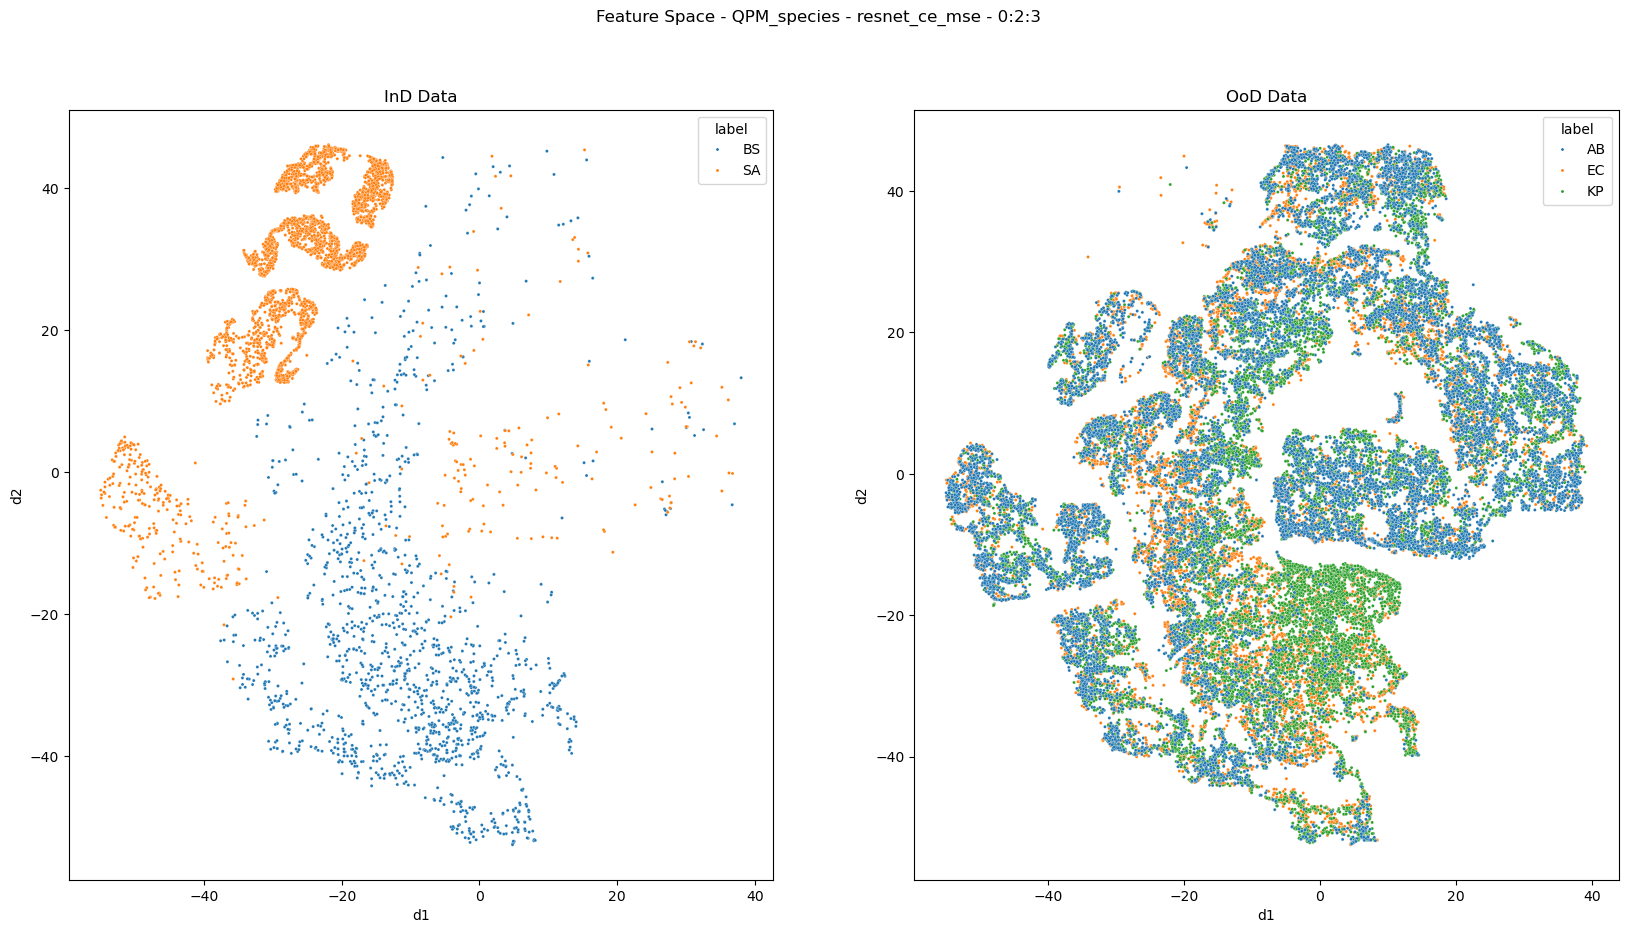

In [13]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

ind_labels = [config.labels[i] for i in ind_tgt]
if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]

df_emb2d = pd.DataFrame()
d1, d2 = ind_emb2d.T
df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_emb2d.T
    df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Feature Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

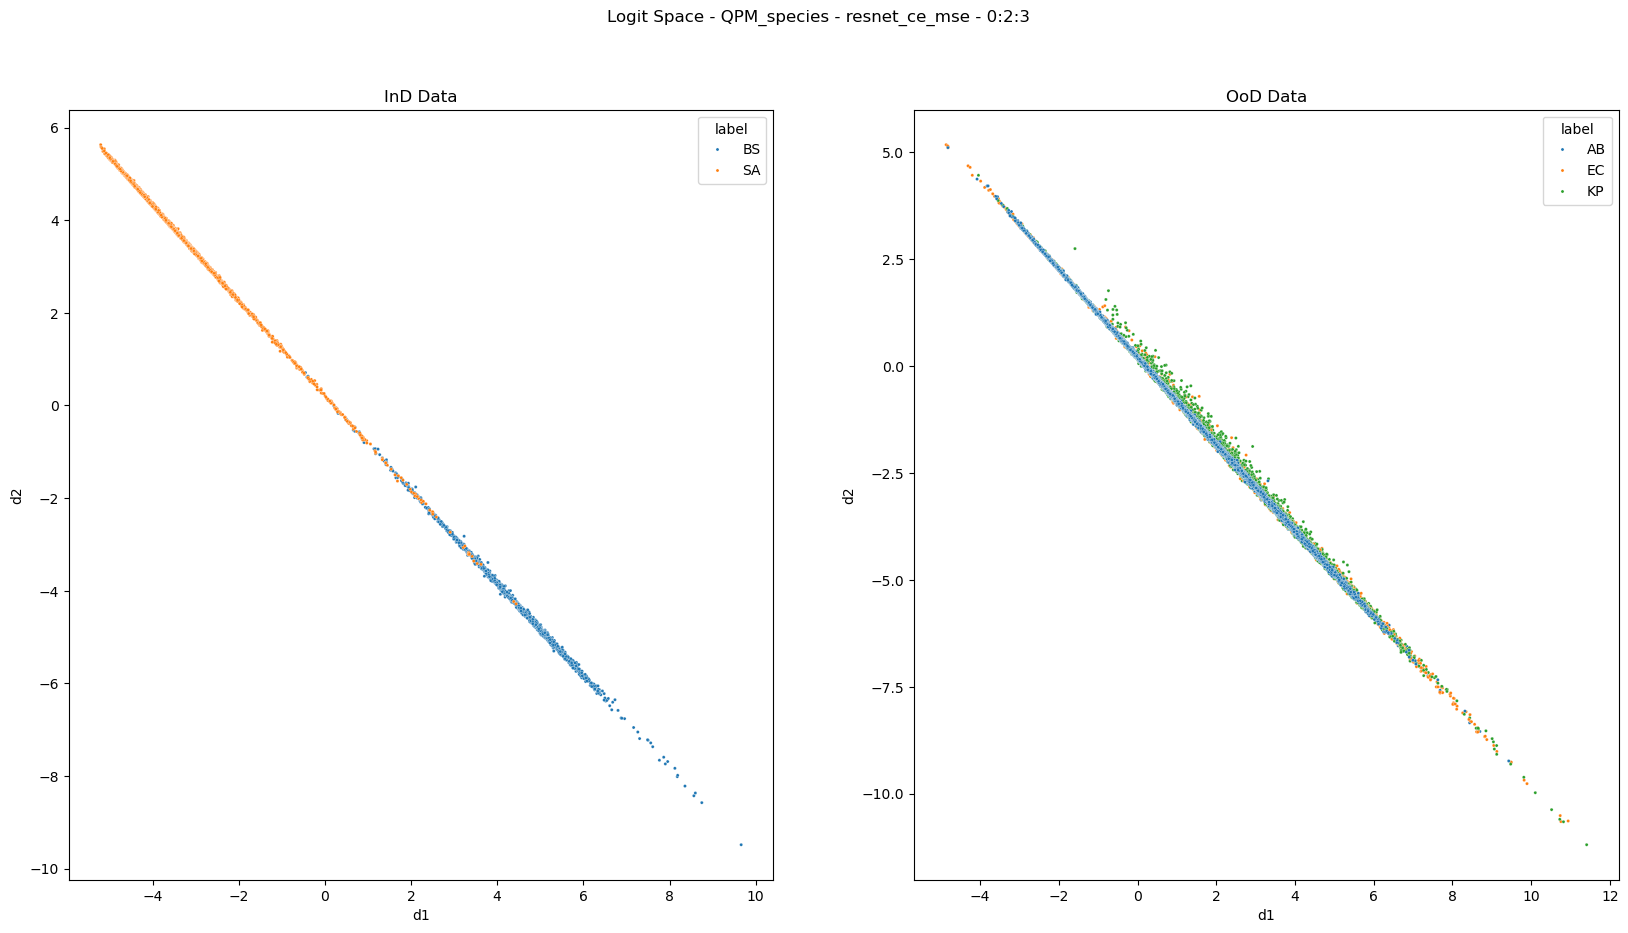

In [14]:
df_lgt2d = pd.DataFrame()
d1, d2 = ind_lgt2d.T
df_lgt2d = pd.concat([df_lgt2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_lgt2d.T
    df_lgt2d = pd.concat([df_lgt2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Logit Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_lgt2d[(df_lgt2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_lgt2d[(df_lgt2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

  0%|                                                                                | 0/4 [00:00<?, ?it/s]

 25%|██████████████████                                                      | 1/4 [00:02<00:06,  2.02s/it]

 50%|████████████████████████████████████                                    | 2/4 [00:04<00:04,  2.15s/it]

 75%|██████████████████████████████████████████████████████                  | 3/4 [00:06<00:02,  2.16s/it]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.23s/it]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.19s/it]

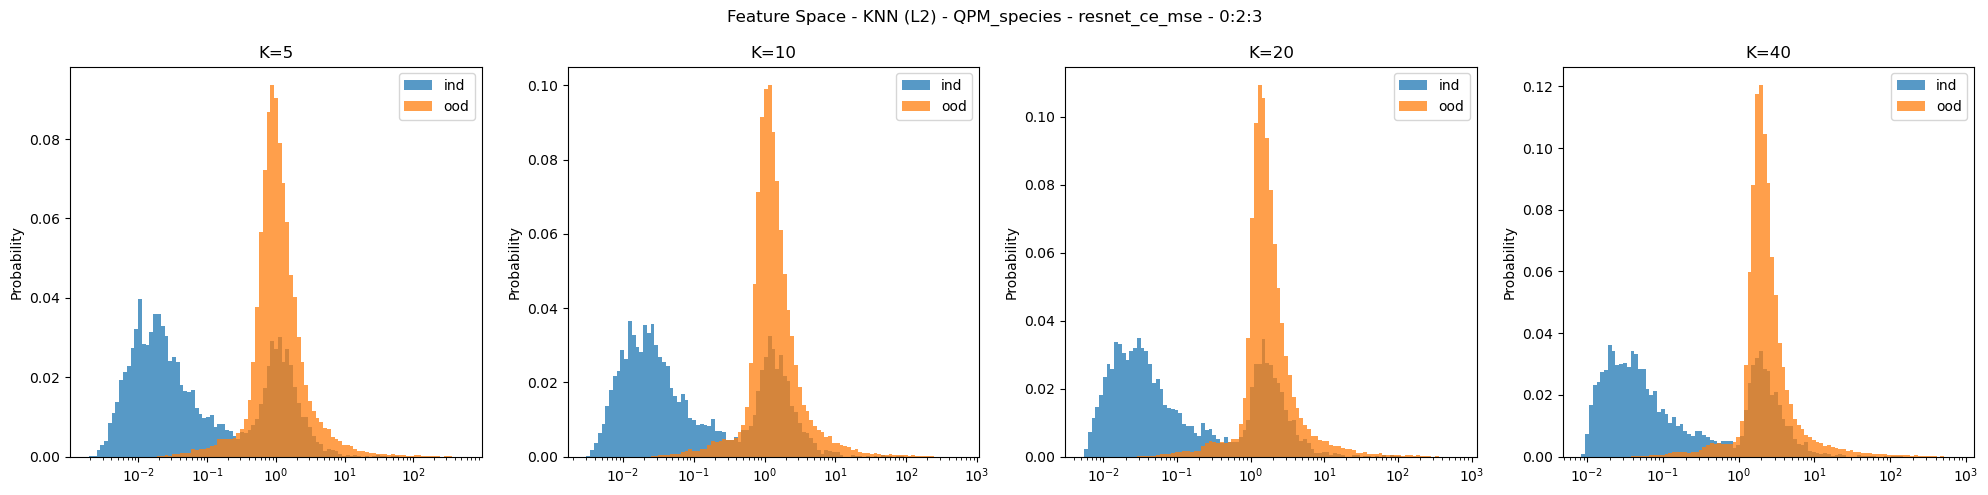

In [15]:
import faiss

index = faiss.IndexFlatL2(ind_emb.shape[-1])
index.add(val_emb)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Feature Space - KNN (L2) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_emb, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_emb, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                | 0/4 [00:00<?, ?it/s]

 25%|██████████████████                                                      | 1/4 [00:01<00:05,  1.90s/it]

 50%|████████████████████████████████████                                    | 2/4 [00:03<00:03,  1.92s/it]

 75%|██████████████████████████████████████████████████████                  | 3/4 [00:05<00:02,  2.02s/it]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.08s/it]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.03s/it]

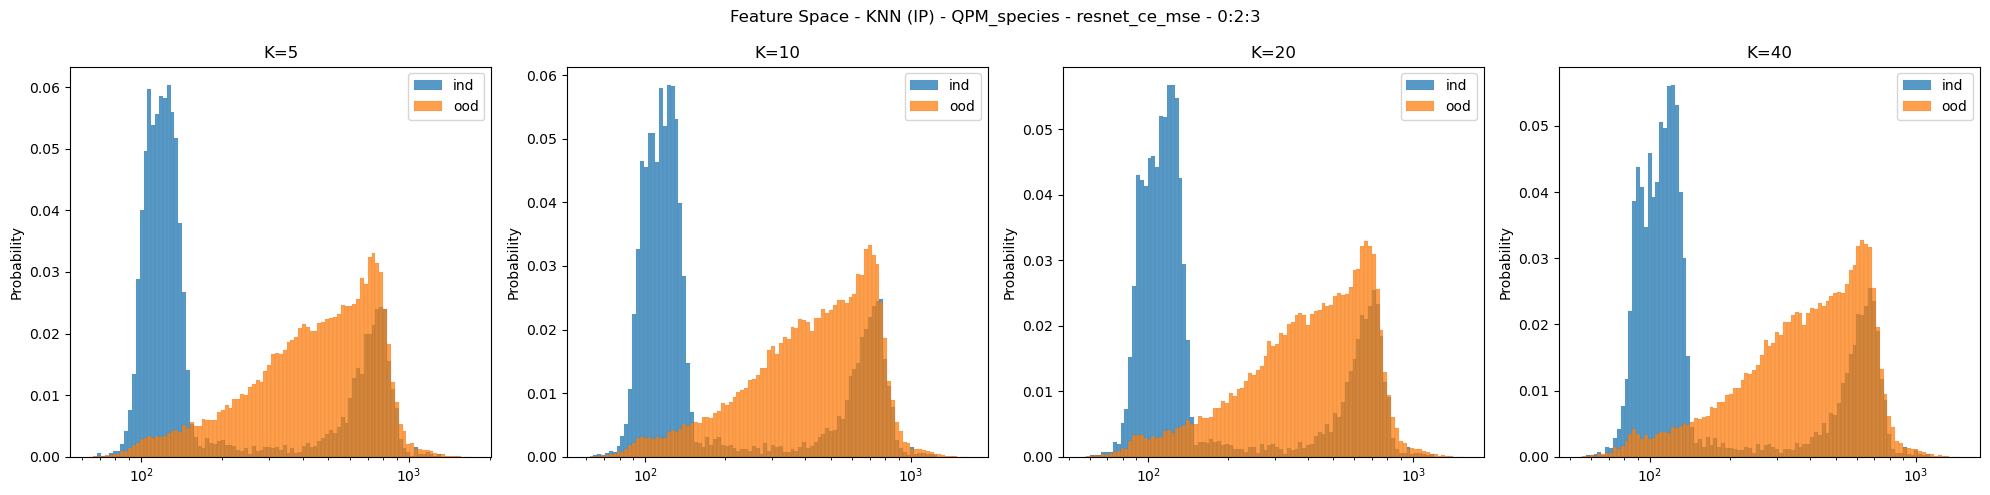

In [16]:
import faiss

index = faiss.IndexFlatIP(ind_emb.shape[-1])
index.add(val_emb)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Feature Space - KNN (IP) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_emb, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_emb, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                | 0/4 [00:00<?, ?it/s]

 25%|██████████████████                                                      | 1/4 [00:00<00:01,  2.56it/s]

 50%|████████████████████████████████████                                    | 2/4 [00:00<00:00,  2.43it/s]

 75%|██████████████████████████████████████████████████████                  | 3/4 [00:01<00:00,  2.19it/s]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.84it/s]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  2.00it/s]

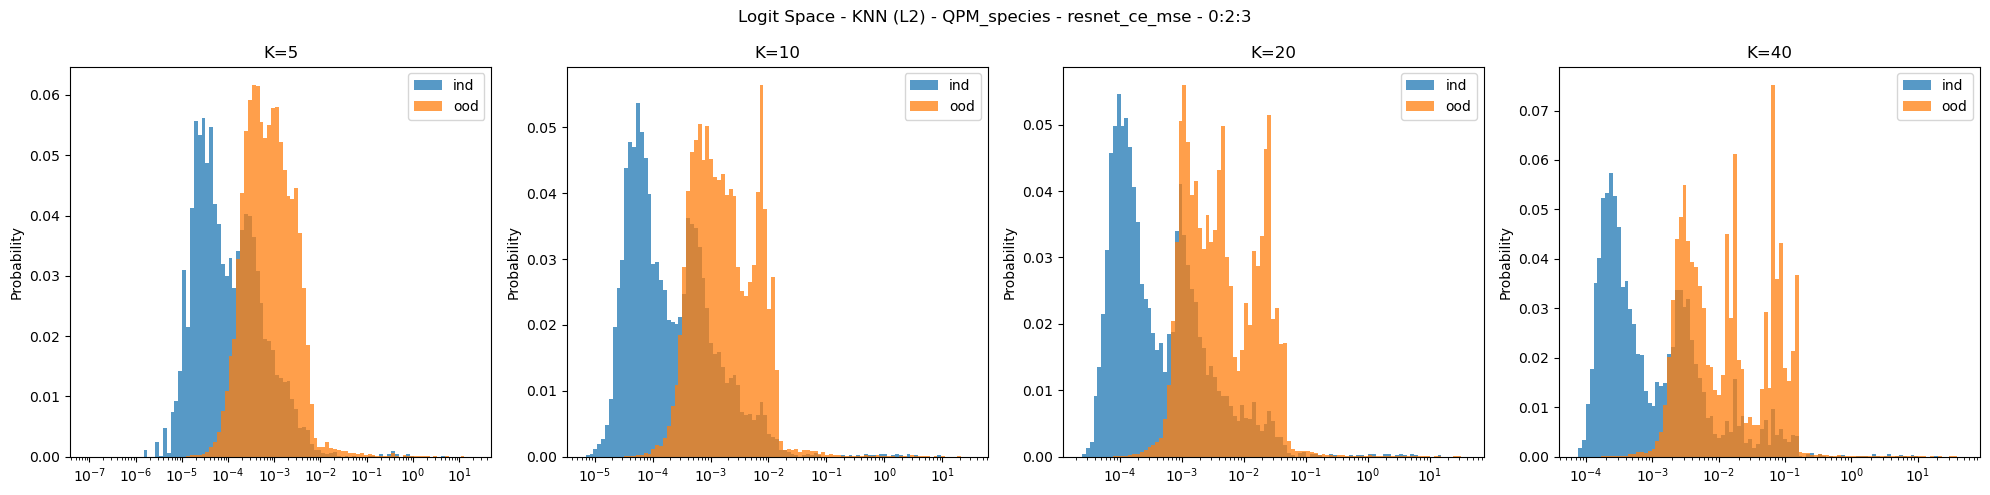

In [17]:
import faiss

index = faiss.IndexFlatL2(ind_lgt.shape[-1])
index.add(val_lgt)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Logit Space - KNN (L2) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_lgt, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_lgt, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                | 0/4 [00:00<?, ?it/s]

 25%|██████████████████                                                      | 1/4 [00:00<00:01,  2.88it/s]

 50%|████████████████████████████████████                                    | 2/4 [00:00<00:00,  2.83it/s]

 75%|██████████████████████████████████████████████████████                  | 3/4 [00:01<00:00,  2.72it/s]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.48it/s]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.58it/s]

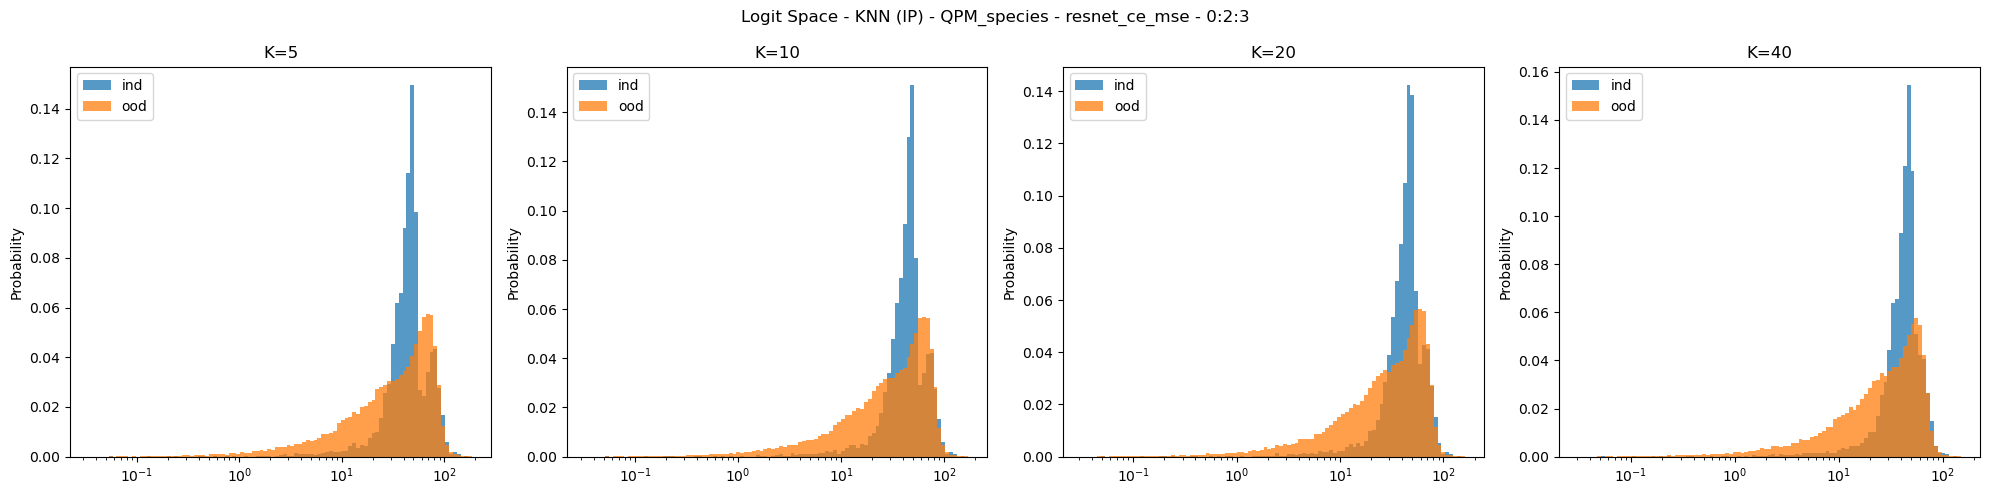

In [18]:
import faiss

index = faiss.IndexFlatIP(ind_lgt.shape[-1])
index.add(val_lgt)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Logit Space - KNN (IP) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_lgt, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_lgt, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

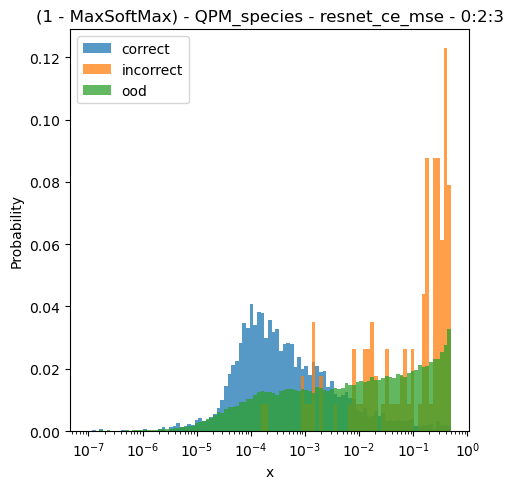

In [19]:
ind_prob = np.exp(ind_lgt) / np.exp(ind_lgt).sum(-1, keepdims=True)
ind_pred = ind_prob.argmax(-1)
ind_ucty = -ind_prob.max(-1) + 1.0

if ood_str:
    ood_prob = np.exp(ood_lgt) / np.exp(ood_lgt).sum(-1, keepdims=True)
    ood_pred = ood_prob.argmax(-1)
    ood_ucty = -ood_prob.max(-1) + 1.0

df_t = pd.DataFrame({"x": ind_ucty[ind_pred == ind_tgt]}).copy()
df_f = pd.DataFrame({"x": ind_ucty[ind_pred != ind_tgt]}).copy()
df = pd.concat([df_t, df_f], ignore_index=True)
if ood_str:
    df_o = pd.DataFrame({"x": ood_ucty}).copy()
    df = pd.concat([df, df_o], ignore_index=True)
df_bins = np.logspace(np.log10(df['x'].min() + 1e-7), np.log10(df['x'].max()), 100)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
sns.histplot(df_t, x="x", label="correct", stat="probability", bins=df_bins, ax=ax)
sns.histplot(df_f, x="x", label="incorrect", stat="probability", bins=df_bins, ax=ax)
if ood_str:
    sns.histplot(df_o, x="x", label="ood", stat="probability", bins=df_bins, ax=ax)
ax.set_xscale("log")
plt.legend()
plt.title(f"(1 - MaxSoftMax) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

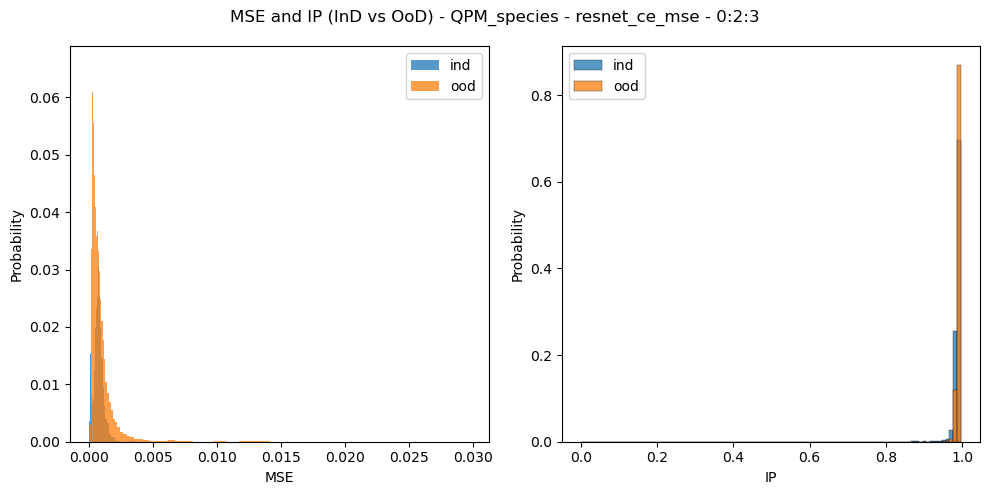

In [20]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

df_rstat = pd.DataFrame()
ni = ind_inp.shape[0]
si = (ni, -1)
_ind_inp = ind_inp.reshape(si)
_ind_rcn = ind_rcn.reshape(si)
_ind_inp_norm = np.linalg.norm(_ind_inp, axis=-1, keepdims=True) + 1e-7
_ind_rcn_norm = np.linalg.norm(_ind_rcn, axis=-1, keepdims=True) + 1e-7
ind_mse = ((_ind_inp - _ind_rcn) ** 2).mean(-1)
ind_ip = ((_ind_inp/_ind_inp_norm) * (_ind_rcn/_ind_rcn_norm)).sum(-1)
df_rstat = pd.concat([df_rstat, pd.DataFrame(dict(target=ind_tgt, mse=ind_mse, ip=ind_ip, source="ind"))], ignore_index=True)

if ood_str:
    no = ood_inp.shape[0]
    so = (no, -1)
    _ood_inp = ood_inp.reshape(so)
    _ood_rcn = ood_rcn.reshape(so)
    _ood_inp_norm = np.linalg.norm(_ood_inp, axis=-1, keepdims=True) + 1e-7
    _ood_rcn_norm = np.linalg.norm(_ood_rcn, axis=-1, keepdims=True) + 1e-7
    ood_mse = ((_ood_inp - _ood_rcn) ** 2).mean(-1)
    ood_ip = ((_ood_inp/_ood_inp_norm) * (_ood_rcn/_ood_rcn_norm)).sum(-1)
    df_rstat = pd.concat([df_rstat, pd.DataFrame(dict(target=ood_tgt, mse=ood_mse, ip=ood_ip, source="ood"))], ignore_index=True)
    
bins_mse = np.logspace(np.log10(df_rstat['mse'].min() + 1e-7), np.log10(df_rstat['mse'].max()), 100)
bins_ip = np.linspace(df_rstat['ip'].min(), df_rstat['ip'].max(), 100)
sns.histplot(df_rstat[df_rstat['source'] == 'ind'], x="mse", label="ind", stat="probability", bins=bins_mse, ax=ax1)
sns.histplot(df_rstat[df_rstat['source'] == 'ind'], x="ip", label="ind", stat="probability", bins=bins_ip, ax=ax2)

if ood_str:
    sns.histplot(df_rstat[df_rstat['source'] == 'ood'], x="mse", label="ood", stat="probability", bins=bins_mse, ax=ax1)
    sns.histplot(df_rstat[df_rstat['source'] == 'ood'], x="ip", label="ood", stat="probability", bins=bins_ip, ax=ax2)

ax1.legend()
ax2.legend()
ax1.set_xlabel("MSE")
ax2.set_xlabel("IP")
plt.suptitle(f"MSE and IP (InD vs OoD) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()